In [1]:
import psi4
from pandas import DataFrame
import numpy as np
import pyopencap
import time

In [2]:
psi4.core.set_output_file('output.dat', False)

In [3]:
mol = psi4.geometry("""
    @He 0.0000000000 0.0000000000 -0.7400000000
    @He 0.0000000000 0.0000000000 0.7400000000
    H 0.0000000000 0.0000000000 0.3705000000
    H 0.0000000000 0.0000000000 -0.3705000000
    Symmetry C1""")

In [4]:
def basisspec_psi4_yo__anonymous03952cbd(mol, role):
    basstrings = {}
    mol.set_basis_all_atoms("test_bas", role=role)
    basstrings['test_bas'] = """
        spherical
        ****
        H    0
        S   3  1.00
        82.6400000000          0.00200600
        12.4100000000          0.01534300
        2.8240000000           0.07557900
        S   1  1.00
        0.7977000000           1.00000000
        S   1  1.00
        0.2581000000           1.00000000
        S   1  1.00
        0.0898900000           1.00000000
        S   1  1.00
        0.0236300000           1.00000000
        P   1  1.00
        2.2920000000           1.00000000
        P   1  1.00
        0.8380000000           1.00000000
        P   1  1.00
        0.2920000000           1.00000000
        P   1  1.00
        0.0848000000           1.00000000
        D   1  1.00
        2.0620000000           1.00000000
        D   1  1.00
        0.6620000000           1.00000000
        D   1  1.00
        0.1900000000           1.00000000
        F   1  1.00
        1.3970000000           1.00000000
        F   1  1.00
        0.3600000000           1.00000000
        ****
He 0
S 1  1.00
0.0118150000 1.00000000
S 1  1.00
0.0059075000 1.00000000
S 1  1.00
0.0029537500 1.00000000
S 1  1.00
0.0014768750 1.00000000
P 1  1.00
0.0424000000 1.00000000
P 1  1.00
0.0212000000 1.00000000
P 1  1.00
0.0106000000 1.00000000
P 1  1.00
0.0053000000 1.00000000
****
        """
    return basstrings

In [5]:
nstates = 30
psi4.qcdb.libmintsbasisset.basishorde['ANONYMOUS03952CBD'] = basisspec_psi4_yo__anonymous03952cbd
psi4.core.set_global_option("BASIS", "anonymous03952cbd")
E, wfn = psi4.energy('scf', return_wfn=True)
mints = psi4.core.MintsHelper(wfn.basisset())
S_mat = np.asarray(mints.ao_overlap())
psi4.molden(wfn, 'h2.molden')
# add 7F to molden file, psi4 doesn't write it for some reason
with open("h2.molden", "a") as myfile:
    myfile.write("\n [7F] \n")

In [6]:
molden_dict = {"basis_file":"h2.molden",
    "molecule": "molden"}
s = pyopencap.System(molden_dict)
s.check_overlap_mat(S_mat,"psi4")
cap_dict = {
    "cap_type": "box",
        "cap_x":"6.00",
            "cap_y":"6.00",
            "cap_z":"6.7",
}
pc = pyopencap.CAP(s,cap_dict,nstates)
pc.compute_ao_cap()

Verified overlap matrix.
Integration time:6.816425


In [8]:
psi4.set_options({"opdm":True,"num_roots":nstates,"tdm":True,"dipmom":True})
ci_energy, ci_wfn = psi4.energy('FCI', return_wfn=True)
h0 = np.zeros((nstates,nstates))
for i in range(0,nstates):
    var_str = 'CI ROOT ' + str(i) + ' TOTAL ENERGY'
    h0[i][i] = float(psi4.get_variable(var_str))

0
-1.173873021673892
1
-0.7055790944336595
2
-0.6918366995996617
3
-0.6883320896161182
4
-0.688332089375068
5
-0.628565801345927
6
-0.6263521958386564
7
-0.6260083768789155
8
-0.6260083768779017
9
-0.6242799818334044
10
-0.623418119527537
11
-0.6234181191920058
12
-0.6024584815655194
13
-0.6006117587787825
14
-0.6005389242378802
15
-0.6004577019621982
16
-0.6004577019415966
17
-0.5992203771773679
18
-0.5962230763119045
19
-0.5962230762827836
20
-0.5905207893515643
21
-0.5889621638778
22
-0.5805289259098247
23
-0.5723091464413779
24
-0.5720750556090517
25
-0.5720750556085874
26
-0.5667890108065261
27
-0.5621941757382678
28
-0.5502891918693529
29
-0.5450828108297239


/home/gayverjr/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using `psi4.core.get_variable` instead of `psi4.core.variable` (or `psi4.core.scalar_variable` for scalar variables only) is deprecated, and in 1.4 it will stop working

  import sys
/home/gayverjr/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using `psi4.core.get_variable` instead of `psi4.core.variable` (or `psi4.core.scalar_variable` for scalar variables only) is deprecated, and in 1.4 it will stop working

  


In [9]:
for i in range(0,nstates):
    for j in range(i,nstates):
        mo_coeff = ci_wfn.Ca()
        opdm_mo = ci_wfn.get_opdm(i, j, "SUM", True)
        opdm_ao = psi4.core.triplet(mo_coeff, opdm_mo, mo_coeff, False, False, True)
        opdm_ao = opdm_ao.to_array(dense=True)
        pc.add_tdm(opdm_ao,i,j,"psi4")
        if not i==j:
            pc.add_tdm(opdm_ao,j,i,"psi4")

In [10]:
pc.compute_projected_cap()
W = pc.get_projected_cap()

In [12]:
from pyopencap.analysis import CAPHamiltonian
CAPH = CAPHamiltonian(H0=h0,W=W)

In [13]:
# only include states of proper symmetry
exclude_states = [1,3,4,5,7,8,10,11,12,15,16,17,18,19,20,21,22,24,25,26,28,29]
eta_list = np.linspace(0,5000,101) * 1E-5
CAPH.run_trajectory(eta_list,exclude_states=exclude_states)

Uncorrected:
(13.144985065145303-0.1117629326115142j)
0.005
Corrected:
(13.141395904055505-0.012027720856517151j)
0.011000000000000001


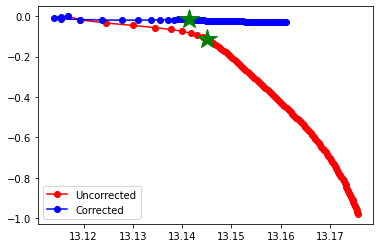

In [20]:
import matplotlib.pyplot as plt
ref_energy = h0[0][0]
traj = CAPH.track_state(1,tracking="overlap")
uc_energies = traj.energies_ev(ref_energy=ref_energy)
corr_energies = traj.energies_ev(ref_energy=ref_energy,corrected=True)
uc_energy, eta_opt = traj.find_eta_opt(start_idx=10)
uc_energy = (uc_energy-ref_energy)*27.2114
corr_energy, corr_eta_opt = traj.find_eta_opt(corrected=True,start_idx=10)
corr_energy = (corr_energy-ref_energy)*27.2114
print("Uncorrected:")
print(uc_energy)
print(eta_opt)
print("Corrected:")
print(corr_energy)
print(corr_eta_opt)
plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
plt.plot(np.real(corr_energies),np.imag(corr_energies),'-bo',label="Corrected")
plt.plot(np.real(uc_energy),np.imag(uc_energy),'g*',markersize=20)
plt.plot(np.real(corr_energy),np.imag(corr_energy),'g*',markersize=20)
plt.legend()
plt.show()